## Importa as libs necessárias para o Notebook

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import numpy as np

## Carga de Arquivos do Treino

In [ ]:
data_path = "/data/raw/treino/"
arquivos_treino = [f for f in os.listdir(data_path) if f.startswith("treino_parte")]

# Carregar os arquivos de treino
df_list = [pd.read_csv(os.path.join(data_path, file)) for file in arquivos_treino]
df_treino = pd.concat(df_list, ignore_index=True)

df_treino.head()

FileNotFoundError: [WinError 3] O sistema não pode encontrar o caminho especificado: '/data/raw/treino/'

## Define uma função para inputar uma categoria aos Itens (notícias)
Define um método que será capaz de distinguir se uma notícia é do G1,GE ou GSHOW (EGO)


In [ ]:
def chooseCategory(url):
    if "g1" in url:
        return "G1"
    if "ge" in url:
        return "GE"
    if "gshow" in url or "ego" in url:
        return "EGO"
    else:        
        return "N/D"

## Carregar os arquivos de itens


In [60]:
itens_path = "../data/raw/news"
arquivos_itens = [f for f in os.listdir(itens_path) if f.startswith("itens-parte")]

# Carregar os arquivos de itens
df_itens_list = [pd.read_csv(os.path.join(itens_path, file)) for file in arquivos_itens]
df_itens = pd.concat(df_itens_list, ignore_index=True)

df_itens.head()


,page,url,issued,modified,title,body,caption
0,13db0ab1-eea2-4603-84c4-f40a876c7400,http://g1.globo.com/am/amazonas/noticia/2022/0...,2022-06-18 20:37:45+00:00,2023-04-15 00:02:08+00:00,Caso Bruno e Dom: 3º suspeito tem prisão tempo...,"Após audiência de custódia, a Justiça do Amazo...",Jeferson da Silva Lima foi escoltado por agent...
1,92907b73-5cd3-4184-8d8c-e206aed2bf1c,http://g1.globo.com/pa/santarem-regiao/noticia...,2019-06-20 17:19:52+00:00,2023-06-16 20:19:15+00:00,Linguajar dos santarenos é diferenciado e chei...,Vista aérea de Santarém\nÁdrio Denner/ AD Prod...,As expressões santarenas não significam apenas...
2,61e07f64-cddf-46f2-b50c-ea0a39c22050,http://g1.globo.com/mundo/noticia/2022/07/08/e...,2022-07-08 08:55:52+00:00,2023-04-15 04:25:39+00:00,Ex-premiê Shinzo Abe morre após ser baleado no...,Novo vídeo mostra que assassino de Shinzo Abe ...,Ex-primeiro-ministro foi atingido por tiros de...
3,30e2e6c5-554a-48ed-a35f-6c6691c8ac9b,http://g1.globo.com/politica/noticia/2021/09/0...,2021-09-09 19:06:46+00:00,2023-06-07 17:44:54+00:00,"Relator no STF, Fachin vota contra marco tempo...","Relator no STF, Fachin vota contra marco tempo...",Ministro defendeu que posse indígena é diferen...
4,9dff71eb-b681-40c7-ac8d-68017ac36675,http://g1.globo.com/politica/noticia/2021/09/1...,2021-09-15 19:16:13+00:00,2023-06-07 17:43:39+00:00,"\nApós 2 votos, pedido de vista suspende julga...",Após um pedido de vista (mais tempo para análi...,"Pelo marco temporal, índios só podem reivindic..."


In [61]:
df_itens = df_itens.drop(columns=["body"])
df_itens["category"] = np.vectorize(chooseCategory)(df_itens["url"])

## Distribuição de categorias de notícias presentes em nossos dados

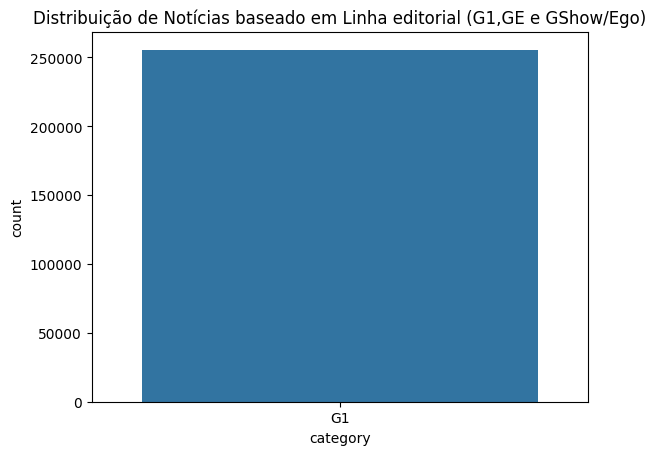

In [62]:
sns.countplot(x= df_itens["category"])
plt.title("Distribuição de Notícias baseado em Linha editorial (G1,GE e GShow/Ego)")
plt.show()


Como podemos ver, todas as nóticias em nossa base de dados são da linha editorial G1. Contudo ao inputarmos uma categoria as notícias, poderemos traçar mais um dado interessante no perfil dos usuários (por qual tipo de notícia mais se interessam, por exemplo)

Sendo assim, mudaremos nosso conceito de categoria para algo além das linhas editorias do Globo, focando agora nos reais tipos (política, cultura, tecnologia, saúde, economia, criminal e geral - abrangendo os demais temas). Para sermos hábeis em atingir tal resultado, poderiamos usar um modelo classificação por exemplo. Contudo, como esse não é o foco do projeto, iremos usar uma forma mais rudimentar (e de longe não tão assertiva), mas que vai nos ajudar a alcançar nossa ideia inicial.

In [ ]:
def chooseCategoryByWordIncidence(url, title, summary):
    categories = {'politica' : {'vota','politica','voto','stf','candidato','presidente','eleicoes','eleição','ministro','congresso','vereador','prefeito','vereadora','prefeita'},
    'cultura' : {'atriz','filme','cultura','cinema','teatro','ator','série','show','música','arte','pop','artista','cantor','cantora','album'},
    'tecnologia' : {'tecnologia','celular','game','console','smartphone','computador','notebook','tablet','streaming','elétrica','elétrico','aparelho','dispositivo'},
    'saude' : {'doença','saúde','saude','bem-estar','epidemia','sintoma','remédio','medicina','médico','tratamento','vacina'},
    'economia' : {'economia','imposto','renda','taxa','salário','tributação','dolar','real','euro','libra','R$','$', 'importar','importação','importacao'},
    'criminal' : {'polícia','prisão','crime','assassinato','sequestro','morte','inocente','culpado','bandido','criminoso','delegado','morto','mandado','morre','morta','facada','arma','tiro'}}
    
    url = url.replace("/", " ").replace("-"," ")
    fulltext = " ".join([url, title, summary])

    counts = dict.fromkeys(categories, 0)
    for word in fulltext.split(" "):
        for cat_name, cat_words in categories.items():
            counts[cat_name] += word.lower() in cat_words
    if(all(x == 0 for x in counts.values())):
        return "geral"
    else:
        return max(counts, key=lambda key: counts[key])

In [89]:
df_itens["category"] = np.vectorize(chooseCategoryByWordIncidence)(df_itens["url"],df_itens["title"],df_itens["caption"])

df_itens.head()

,page,url,issued,modified,title,caption,category
0,13db0ab1-eea2-4603-84c4-f40a876c7400,http://g1.globo.com/am/amazonas/noticia/2022/0...,2022-06-18 20:37:45+00:00,2023-04-15 00:02:08+00:00,Caso Bruno e Dom: 3º suspeito tem prisão tempo...,Jeferson da Silva Lima foi escoltado por agent...,criminal
1,92907b73-5cd3-4184-8d8c-e206aed2bf1c,http://g1.globo.com/pa/santarem-regiao/noticia...,2019-06-20 17:19:52+00:00,2023-06-16 20:19:15+00:00,Linguajar dos santarenos é diferenciado e chei...,As expressões santarenas não significam apenas...,geral
2,61e07f64-cddf-46f2-b50c-ea0a39c22050,http://g1.globo.com/mundo/noticia/2022/07/08/e...,2022-07-08 08:55:52+00:00,2023-04-15 04:25:39+00:00,Ex-premiê Shinzo Abe morre após ser baleado no...,Ex-primeiro-ministro foi atingido por tiros de...,criminal
3,30e2e6c5-554a-48ed-a35f-6c6691c8ac9b,http://g1.globo.com/politica/noticia/2021/09/0...,2021-09-09 19:06:46+00:00,2023-06-07 17:44:54+00:00,"Relator no STF, Fachin vota contra marco tempo...",Ministro defendeu que posse indígena é diferen...,politica
4,9dff71eb-b681-40c7-ac8d-68017ac36675,http://g1.globo.com/politica/noticia/2021/09/1...,2021-09-15 19:16:13+00:00,2023-06-07 17:43:39+00:00,"\nApós 2 votos, pedido de vista suspende julga...","Pelo marco temporal, índios só podem reivindic...",politica


Agora, foi possível melhor categorizar os nossos dados, com isso inputamos um novo valor que será bem interessante na hora de treinarmos o nosso modelo para sugerir as "próximas" matérias para um histórico de usuário

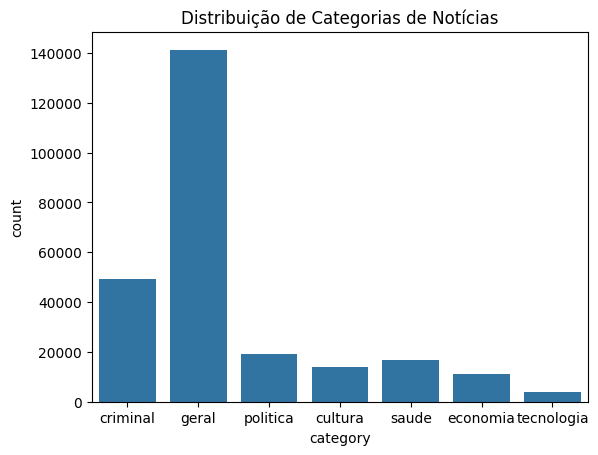

In [90]:
sns.countplot(x= df_itens["category"])
plt.title("Distribuição de Categorias de Notícias")
plt.show()

## Distribuição de Usuários e Tipos
verificando quantos usuários estão logados vs não logados


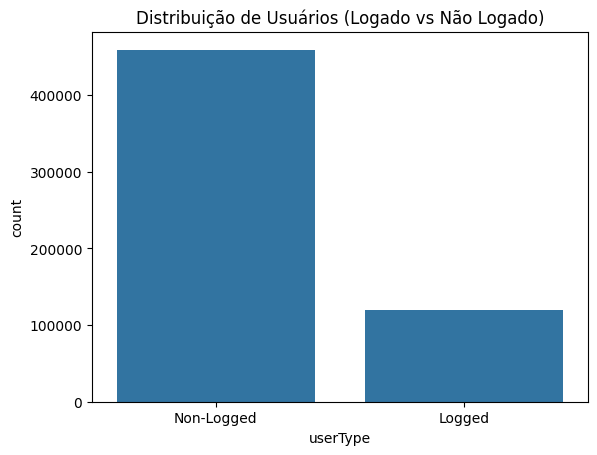

In [ ]:

# Contagem de tipos de usuários
sns.countplot(x=df_treino['userType'])
plt.title("Distribuição de Usuários (Logado vs Não Logado)")
plt.show()


## Análise dos Turnos de mais acesso

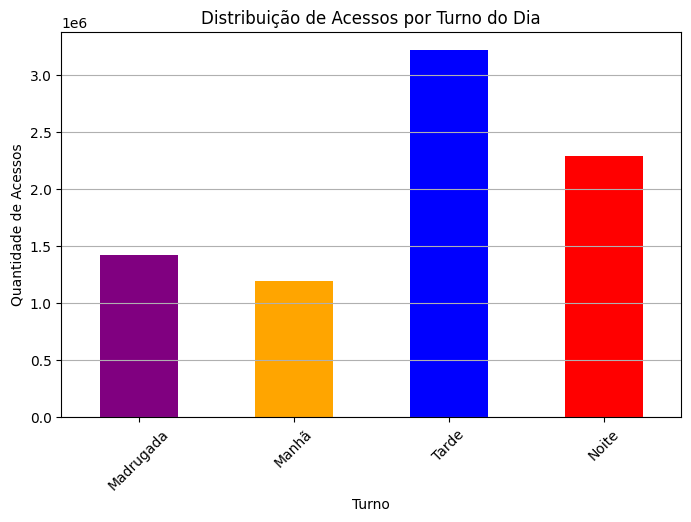

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

df_timestamps = df_treino[['timestampHistory_new']].dropna().copy()
df_timestamps['timestampHistory_new'] = df_timestamps['timestampHistory_new'].astype(str).str.split(',')  # Separar timestamps
df_timestamps = df_timestamps.explode('timestampHistory_new')  # Criar linhas separadas

# Converter para datetime
df_timestamps['timestampHistory_new'] = pd.to_numeric(df_timestamps['timestampHistory_new'], errors='coerce')
df_timestamps.dropna(subset=['timestampHistory_new'], inplace=True)  # Remover valores inválidos
df_timestamps['timestampHistory_new'] = pd.to_datetime(df_timestamps['timestampHistory_new'], unit='ms')  # Converter para datetime

df_timestamps['hora'] = df_timestamps['timestampHistory_new'].dt.hour

def classificar_turno(hora):
    if 5 <= hora < 12:
        return "Manhã"
    elif 12 <= hora < 18:
        return "Tarde"
    elif 18 <= hora < 23:
        return "Noite"
    else:
        return "Madrugada"

df_timestamps['turno'] = df_timestamps['hora'].apply(classificar_turno)

turno_counts = df_timestamps['turno'].value_counts().reindex(["Madrugada", "Manhã", "Tarde", "Noite"])

plt.figure(figsize=(8,5))
turno_counts.plot(kind='bar', color=['purple', 'orange', 'blue', 'red'])
plt.title("Distribuição de Acessos por Turno do Dia")
plt.xlabel("Turno")
plt.ylabel("Quantidade de Acessos")
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.show()


## Tempo Médio por Turno

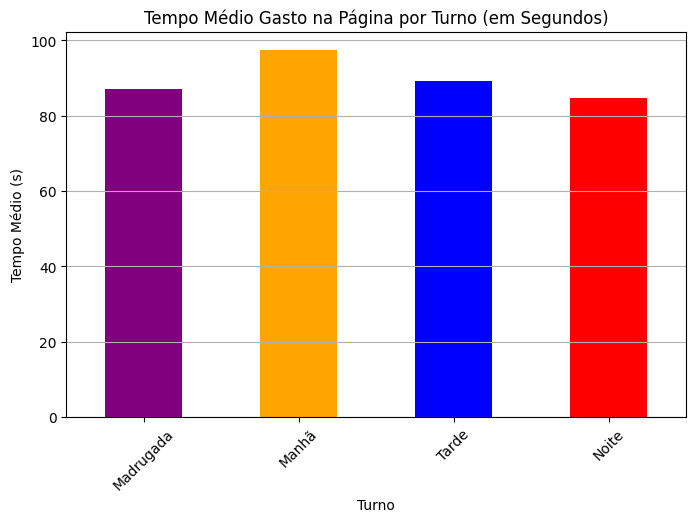

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df_timestamps = df_treino[['timestampHistory_new', 'timeOnPageHistory']].dropna().copy()

df_timestamps['timestampHistory_new'] = df_timestamps['timestampHistory_new'].astype(str).str.split(',')
df_timestamps['timeOnPageHistory'] = df_timestamps['timeOnPageHistory'].astype(str).str.split(',')

df_timestamps = df_timestamps.explode(['timestampHistory_new', 'timeOnPageHistory'])

# Converter para datetime
df_timestamps['timestampHistory_new'] = pd.to_numeric(df_timestamps['timestampHistory_new'], errors='coerce')
df_timestamps.dropna(subset=['timestampHistory_new'], inplace=True)
df_timestamps['timestampHistory_new'] = pd.to_datetime(df_timestamps['timestampHistory_new'], unit='ms')

# Criar nova coluna de hora
df_timestamps['hora'] = df_timestamps['timestampHistory_new'].dt.hour

# Converte parasegundos
df_timestamps['timeOnPageHistory'] = pd.to_numeric(df_timestamps['timeOnPageHistory'], errors='coerce')
df_timestamps['timeOnPageHistory'] = df_timestamps['timeOnPageHistory'] / 1000  # Convertendo para segundos

def classificar_turno(hora):
    if 5 <= hora < 12:
        return "Manhã"
    elif 12 <= hora < 18:
        return "Tarde"
    elif 18 <= hora < 23:
        return "Noite"
    else:
        return "Madrugada"

df_timestamps['turno'] = df_timestamps['hora'].apply(classificar_turno)

tempo_medio_turno = df_timestamps.groupby('turno')['timeOnPageHistory'].mean().reindex(["Madrugada", "Manhã", "Tarde", "Noite"])

plt.figure(figsize=(8,5))
tempo_medio_turno.plot(kind='bar', color=['purple', 'orange', 'blue', 'red'])
plt.title("Tempo Médio Gasto na Página por Turno (em Segundos)")
plt.xlabel("Turno")
plt.ylabel("Tempo Médio (s)")
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.show()
